# Exercise 1: Wine Classification!

In [1]:
# Load packages we need
import sys
import os

import numpy as np
import sklearn

import scipy.stats as stats
import scipy as sp

import pandas as pd


%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scipy version: ' + sp.__version__)
print('### Pandas version: ' + pd.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots

### Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
### Numpy version: 1.19.5
### Scipy version: 1.5.0
### Pandas version: 1.0.5
### Scikit-learn version: 0.23.1
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

np.random.seed(seed) # deterministic seed for reproducibility

## Interesting stuff starts now

### Loading data

In [3]:
# Use pandas to load the data from compressed CSV
#wine_type = 'red'
wine_type = 'white'

df = pd.read_csv('../data/{}-wine-quality.csv'.format(wine_type), header=0, na_values='?', sep=' *; *', skipinitialspace=True, engine='python')

In [4]:
# Check that we loaded the data as expected
if wine_type == 'white':
    df_expected_shape = (4898,12)
else:
    df_expected_shape = (1599,12)
    
assert df.shape == df_expected_shape, 'Unexpected shape of df!'

In [5]:
# Quick tip: use info() to get a glance at the size and attributes of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [6]:
# Let's look at a few rows of our dataframe
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [7]:
# how many records do we have?
df.shape

(4898, 12)

### Pre-processing data

In [8]:
## header right now: fixed acidity;volatile acidity;citric acid;residual sugar;chlorides;free sulfur dioxide;total sulfur dioxide;density;pH;sulphates;alcohol;quality
col_names = df.columns
col_names = [x for x in col_names]

#### all columns are numerical and the last one 'quality' is what we want to predict
#### Note: quality is a score between 0 (very bad) and 10 (excellent)

In [9]:
# grab all the data as a numpy array
all_xy = np.asarray(df, dtype='float64')
assert all_xy.shape[1] == 12

label_col_idx = all_xy.shape[1]-1
features_col_idx = range(0, label_col_idx)

#### Let's separate features from labels

In [10]:
# separate features from the label
all_x = all_xy[:,features_col_idx]
all_y = all_xy[:,label_col_idx]
all_y = all_y.astype(int)

### Train, Test, Validation Split

In [11]:
# now split between train, test, and validation
prop_vec = [14, 3, 3]
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x, all_y, prop_vec, shuffle=True, seed=seed)

In [12]:
# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((3429, 11), (3429,), (735, 11), (735,), (734, 11), (734,))

### Stats & Looking at the data

In [13]:
# what does the distribution of labels look like?
label_name = col_names[-1]
utils.print_array_hist(train_y, label=label_name)

--- quality ---
3: 13
4: 112
5: 1028
6: 1536
7: 607
8: 129
9: 4


### Clearly, this is not a balanced dataset! (We will see later on why this can matter.)

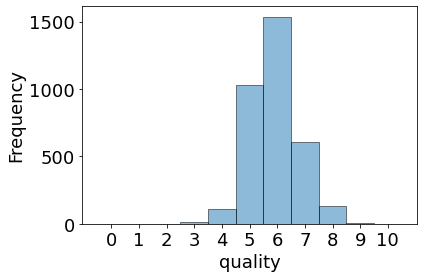

In [14]:
# let's plot a histogram to visualize the distribution of labels
bins = np.arange(-1, 11) + 0.5

plt.hist(train_y, bins, density=False, alpha=0.5, edgecolor='k', label=label_name)

plt.xticks(np.arange(11))
plt.xlabel(label_name)
plt.ylabel('Frequency')
plt.show()

### Question: what do you think is a good baseline for predicting the quality exactly?

In [15]:
# what does the distribution of features look like?
for i in range(train_x.shape[1]):
    utils.print_array_basic_stats(train_x[:, i], label=col_names[i])
    print()

--- fixed acidity ---
min: 4.20
max: 10.70
mean (+- std): 6.85 (+- 0.83)

--- volatile acidity ---
min: 0.08
max: 1.10
mean (+- std): 0.28 (+- 0.10)

--- citric acid ---
min: 0.00
max: 1.23
mean (+- std): 0.33 (+- 0.12)

--- residual sugar ---
min: 0.60
max: 65.80
mean (+- std): 6.34 (+- 5.10)

--- chlorides ---
min: 0.01
max: 0.30
mean (+- std): 0.05 (+- 0.02)

--- free sulfur dioxide ---
min: 2.00
max: 289.00
mean (+- std): 35.25 (+- 17.23)

--- total sulfur dioxide ---
min: 18.00
max: 440.00
mean (+- std): 137.70 (+- 42.01)

--- density ---
min: 0.99
max: 1.04
mean (+- std): 0.99 (+- 0.00)

--- pH ---
min: 2.77
max: 3.81
mean (+- std): 3.19 (+- 0.15)

--- sulphates ---
min: 0.22
max: 1.08
mean (+- std): 0.49 (+- 0.12)

--- alcohol ---
min: 8.00
max: 14.05
mean (+- std): 10.52 (+- 1.23)



### Question: Do the features even help us predict the quality?

In [16]:
# The larger the overlapping area is potentially the less useful the feature is for prediction

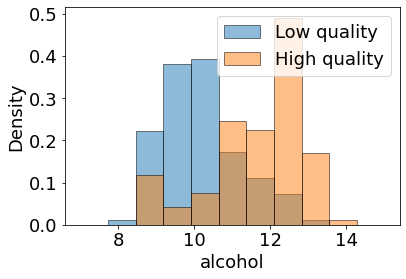

In [17]:
# plot feature distribution based on quality

#feature_idx = 0; bins = np.linspace(3, 12, 12)
#feature_idx = 3; bins = np.linspace(0, 70, 20)
feature_idx = 10; bins = np.linspace(7, 15, 12)

lowq_idx = train_y == 4 # low quality wines
highq_idx = train_y == 8 # high quality wines

plt.hist(train_x[lowq_idx,feature_idx], bins, density=True, alpha=0.5, edgecolor='k', label='Low quality')
plt.hist(train_x[highq_idx,feature_idx], bins, density=True, alpha=0.5, edgecolor='k', label='High quality')

plt.xlabel('{}'.format(col_names[feature_idx]))
plt.ylabel('Density')

plt.legend(loc='upper right')
plt.show()

### Can we look at the statistical information that features contain about the task in a systematic way?

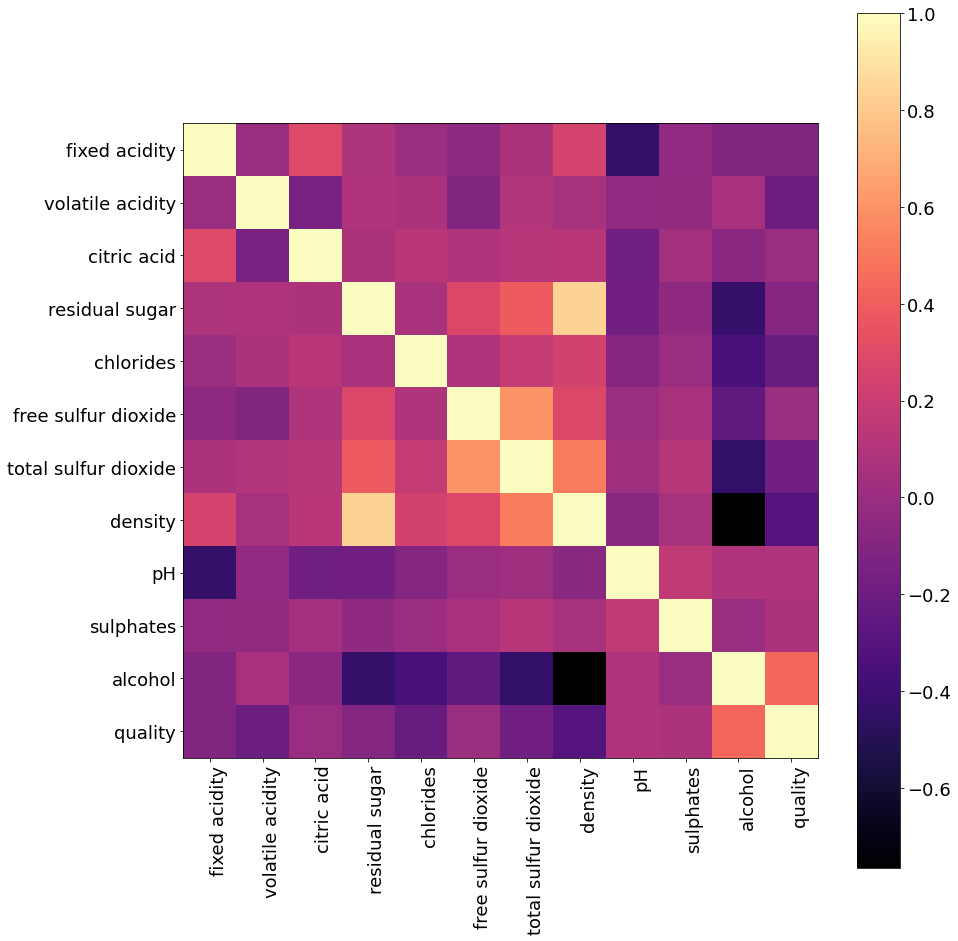

In [18]:
# Hint: this may be in your assignment!

train_xy = np.hstack((train_x, train_y.reshape(-1, 1)))

pairwise_corr = np.corrcoef(train_xy, rowvar=False)

plots.heatmap(pairwise_corr, col_names, col_names, rot=90, fsz=(14, 14))

### [Left as exercise]: use Pandas' scatter_matrix to look at scatter plots for the correlation. *Good exercise

In [19]:
## Ref: https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html

### Should we scale features?

In [20]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True)
scaler.fit(train_x) # fit on the training set! Why?

train_x_scaled = scaler.transform(train_x)
test_x_scaled = scaler.transform(test_x)
val_x_scaled = scaler.transform(val_x)

#note:  we don't scale y. Q: why not?

In [ ]:
# Many models like SVM cannot handle features at different scale.
# It is hard for models to converge when features are not at the same scale.
# We also want to rescale features in small numbers like [0, 1] because the precission expression ablity is limited of computer.

## Let's train a model

#### SVM classifier

In [25]:
from sklearn.base import clone
import time

# note: training the SVM could take a while (why?)

# Step 1: instantiate the model and set hyperparameters
## refer to: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svm = SVC(kernel='linear', random_state=seed)
svm_scaled = clone(svm)

# Step 2: train the model (we use the training set)
st = time.time()
svm.fit(train_x, train_y)
et1 = time.time()
_ = svm_scaled.fit(train_x_scaled, train_y)
et2 = time.time()

print('[Training Time] unscaled: {} seconds, scaled: {} seconds'. format(et1 - st, et2 - et1))

[Training Time] unscaled: 142.03984999656677 seconds, scaled: 0.5341169834136963 seconds


#### KNN classifier

In [26]:
# Step 1: instantiate the model and set hyperparameters
## refer to: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
knn = KNeighborsClassifier(n_neighbors=1)
knn_scaled = clone(knn)

# Step 2: train the model (we use the training set)
st = time.time()
knn.fit(train_x, train_y)
et1 = time.time()
_ = knn_scaled.fit(train_x_scaled, train_y)
et2 = time.time()

print('[Training Time] unscaled: {} seconds, scaled: {} seconds'. format(et1 - st, et2 - et1))

[Training Time] unscaled: 0.0032629966735839844 seconds, scaled: 0.002421855926513672 seconds


### Let's evaluate our models!

In [23]:
# Evaluate the models
# define a function to calculate accuracy
def model_accuracy(model, x, true_y):
    pred = model.predict(x)
    return np.sum(pred == true_y) / true_y.shape[0]

def evaluate_model(name, model, train_x, train_y, val_x, val_y):
    train_acc = model_accuracy(model, train_x, train_y)
    val_acc = model_accuracy(model, val_x, val_y)
    print('[{}] Training accuracy: {:.2f}%, Validation accuracy: {:.2f}%'.format(name, train_acc*100, val_acc*100))
    
evaluate_model('SVM', svm, train_x, train_y, val_x, val_y)
evaluate_model('SVM (w/ scaled features)', svm_scaled, train_x_scaled, train_y, val_x_scaled, val_y)
evaluate_model('KNN', knn, train_x, train_y, val_x, val_y)
evaluate_model('KNN (w/ scaled features)', knn_scaled, train_x_scaled, train_y, val_x_scaled, val_y)

[SVM] Training accuracy: 52.67%, Validation accuracy: 52.72%
[SVM (w/ scaled features)] Training accuracy: 52.79%, Validation accuracy: 52.45%
[KNN] Training accuracy: 100.00%, Validation accuracy: 55.86%
[KNN (w/ scaled features)] Training accuracy: 100.00%, Validation accuracy: 64.44%


### Q: Does scaling features make a difference?

### Q: Wait. What's going on with 100% accuracy?

### Q: Is around 50% a good model? Why or why not?